# STROKE DATA EXPLORATION

# 1. Import library and load dataset

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import KBinsDiscretizer, OrdinalEncoder, OneHotEncoder
import seaborn
from imblearn.over_sampling import SMOTE, SVMSMOTE, BorderlineSMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule, RandomUnderSampler
from imblearn.combine import SMOTETomek, SMOTEENN
from imblearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier

filename = "healthcare-dataset-stroke-data.csv"
data = pd.read_csv(filename, index_col="id")
features = ['age', 'avg_glucose_level', 'bmi', 'smoking_status', 'gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type']   #
target = 'stroke'

# 2. Summarize Data

## 2.1) Descriptive statistics

### View few first rows

In [2]:
data.head(10)

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
id,,,,,,,,,,,
9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1
60182,Female,49.0,0,0,Yes,Private,Urban,171.23,34.4,smokes,1
1665,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.0,never smoked,1
56669,Male,81.0,0,0,Yes,Private,Urban,186.21,29.0,formerly smoked,1
53882,Male,74.0,1,1,Yes,Private,Rural,70.09,27.4,never smoked,1
10434,Female,69.0,0,0,No,Private,Urban,94.39,22.8,never smoked,1
27419,Female,59.0,0,0,Yes,Private,Rural,76.15,NaN,Unknown,1


### Dimensions of data

In [3]:
data.shape

(5110, 11)

### Data type of each attribute

In [4]:
data.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married          object
work_type             object
Residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
dtype: object

### Statistical summary

In [5]:
data.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


We pay attention to the `bmi` attribute which has 4909 observations summarized whereas other attributes have 5110 observations. This imply `bmi` might have missing values.

### Class distribution

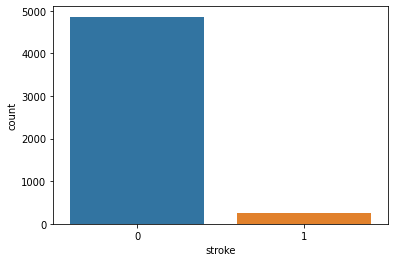

In [6]:
seaborn.countplot(x='stroke', data=data)
pyplot.savefig("./exploration_figures/class_distribution.png")
pyplot.show()

In [7]:
data['stroke'].value_counts()

0    4861
1     249
Name: stroke, dtype: int64

Our dataset is severely imbalanced: $\frac{\text{#stroke}}{\text{#not stroke}} = \frac{1}{20}$

### Identify Columns That Have Very Few Values

In [8]:
categorical_ix = []
numerical_ix = []
n_uniques = data.nunique()
print("Number of unique values in each columns")
print("{:<20}{:>8}{:>12}\t {}".format("Column", "n_unique", "Percentage", "Unique values"))
print("-----------------------------------------------------------------------------------------")
for col in data.columns:
    percentage = n_uniques[col] / data.shape[0] * 100
    if percentage < 1:
        categorical_ix.append(col)
    else:
        numerical_ix.append(col)
    print("{:<20}{:>8}{:>12.1f}%\t".format(col, n_uniques[col], percentage), (data[col].unique() if percentage < 1 else ""))

# Remove outlier associated with `age` (only 1 outlier)
data = data[data['gender'] != "Other"]

Number of unique values in each columns
Column              n_unique  Percentage	 Unique values
-----------------------------------------------------------------------------------------
gender                     3         0.1%	 ['Male' 'Female' 'Other']
age                      104         2.0%	 
hypertension               2         0.0%	 [0 1]
heart_disease              2         0.0%	 [1 0]
ever_married               2         0.0%	 ['Yes' 'No']
work_type                  5         0.1%	 ['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
Residence_type             2         0.0%	 ['Urban' 'Rural']
avg_glucose_level       3979        77.9%	 
bmi                      418         8.2%	 
smoking_status             4         0.1%	 ['formerly smoked' 'never smoked' 'smokes' 'Unknown']
stroke                     2         0.0%	 [1 0]


Luckily, we don't have any single-value columns.

## 2.2) Data visualizations

### Univariate Plots

#### Histograms

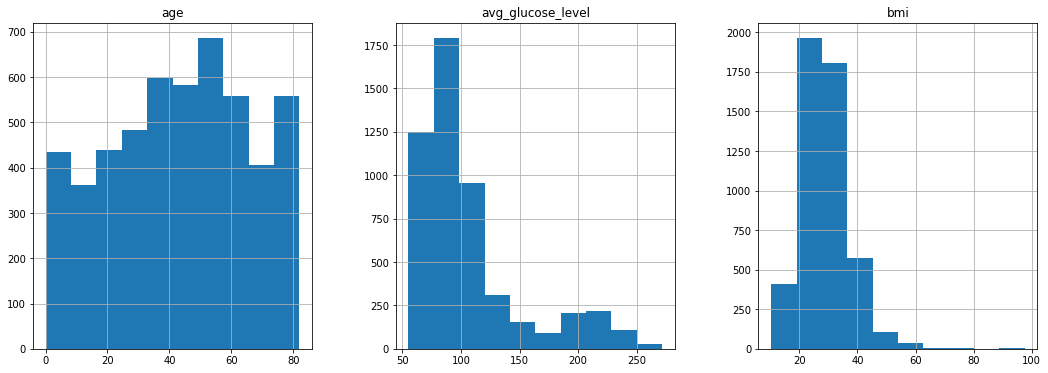

In [9]:
data[numerical_ix].hist(figsize=(18, 6), layout=(1, 3))
pyplot.show()

#### Density Plots

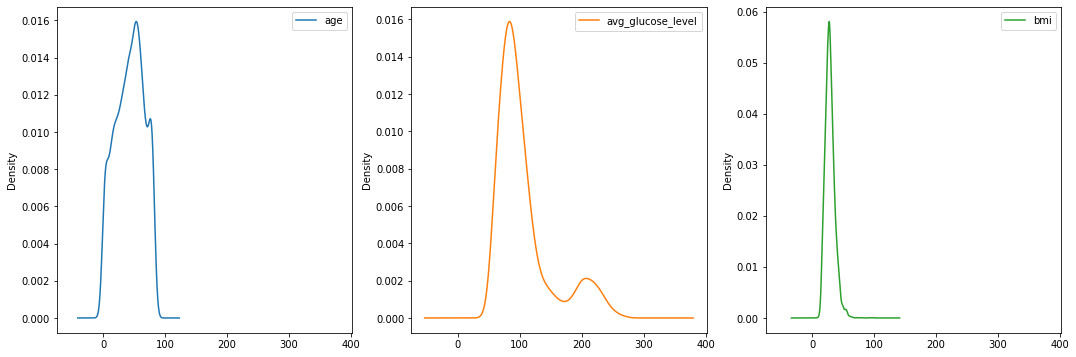

In [10]:
data[numerical_ix].plot(kind='density', subplots=True, layout=(1,3), figsize=(18, 6))
pyplot.show()

#### Box and Whisker Plots

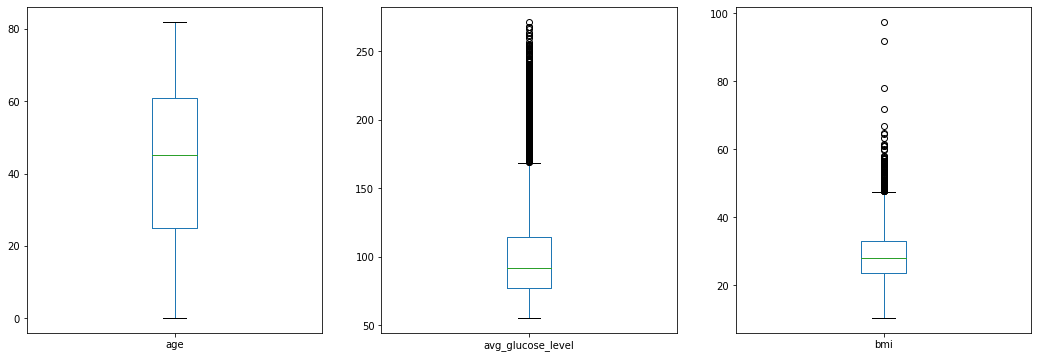

In [11]:
data[numerical_ix].plot(kind='box', subplots=True, layout=(1, 3), figsize=(18, 6))
pyplot.savefig("./exploration_figures/boxplot_before.png")
pyplot.show()

#### Bar Plots

<Figure size 1584x1584 with 0 Axes>

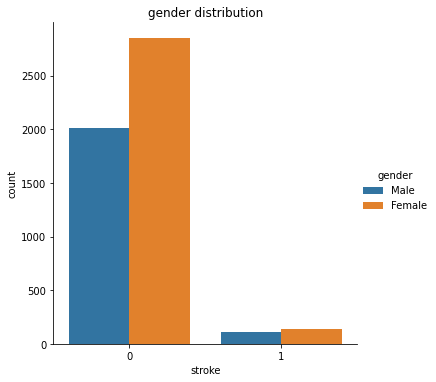

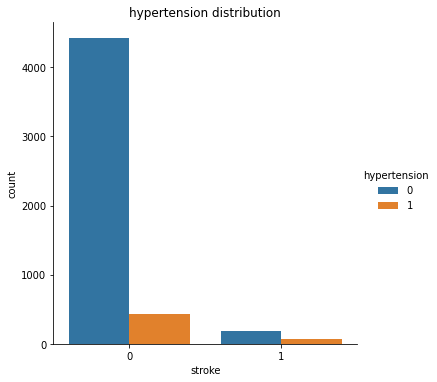

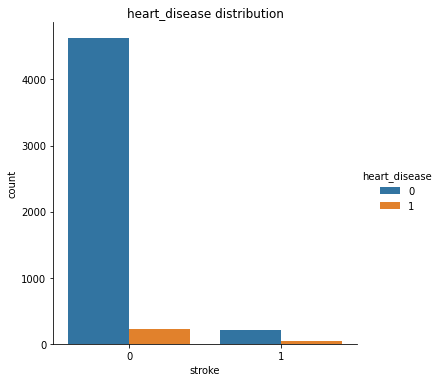

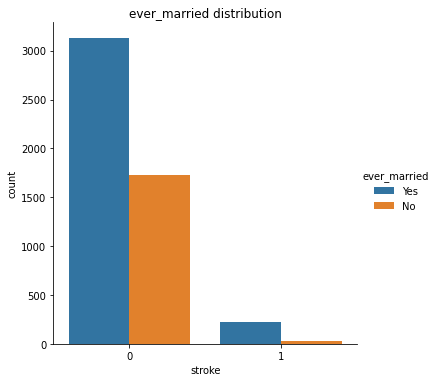

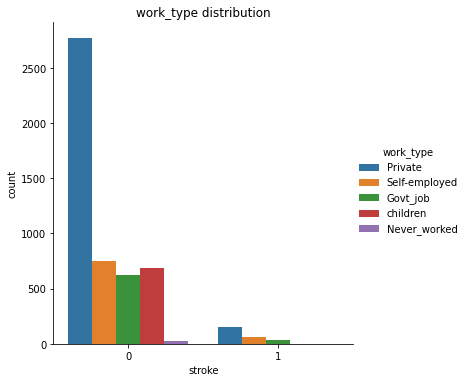

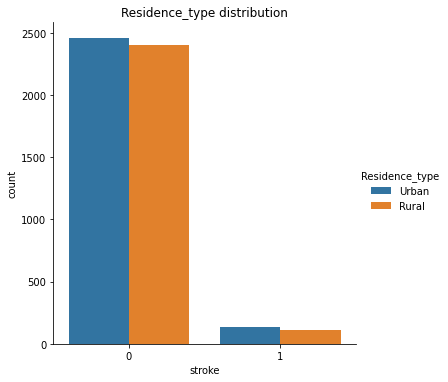

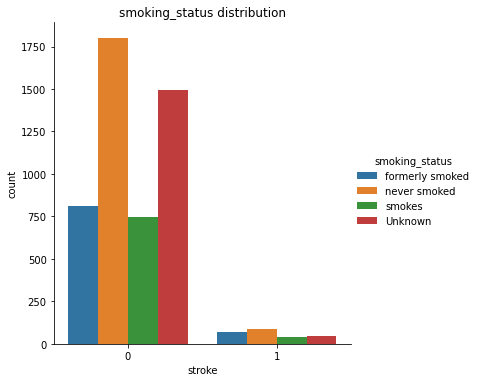

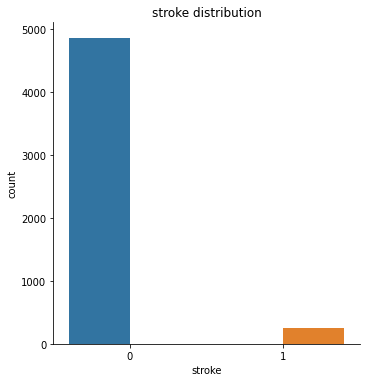

In [12]:
pyplot.figure(figsize=(22, 22))
for i in range(len(categorical_ix)):
    # pyplot.subplot(3, 3, i + 1)
    seaborn.catplot(x='stroke', kind='count', data=data, hue=categorical_ix[i])
    pyplot.title(categorical_ix[i] + ' distribution')
pyplot.show()

### Multivariate Plots

#### Correlation Matrix Plot

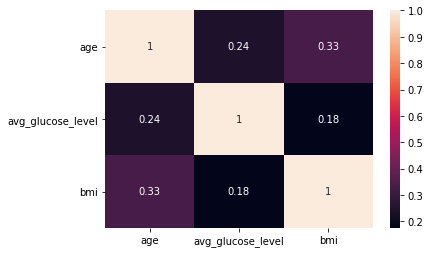

In [13]:
correlations = data[numerical_ix].corr(method='pearson')
seaborn.heatmap(correlations, annot=True)
pyplot.show()

#### Pair Plots

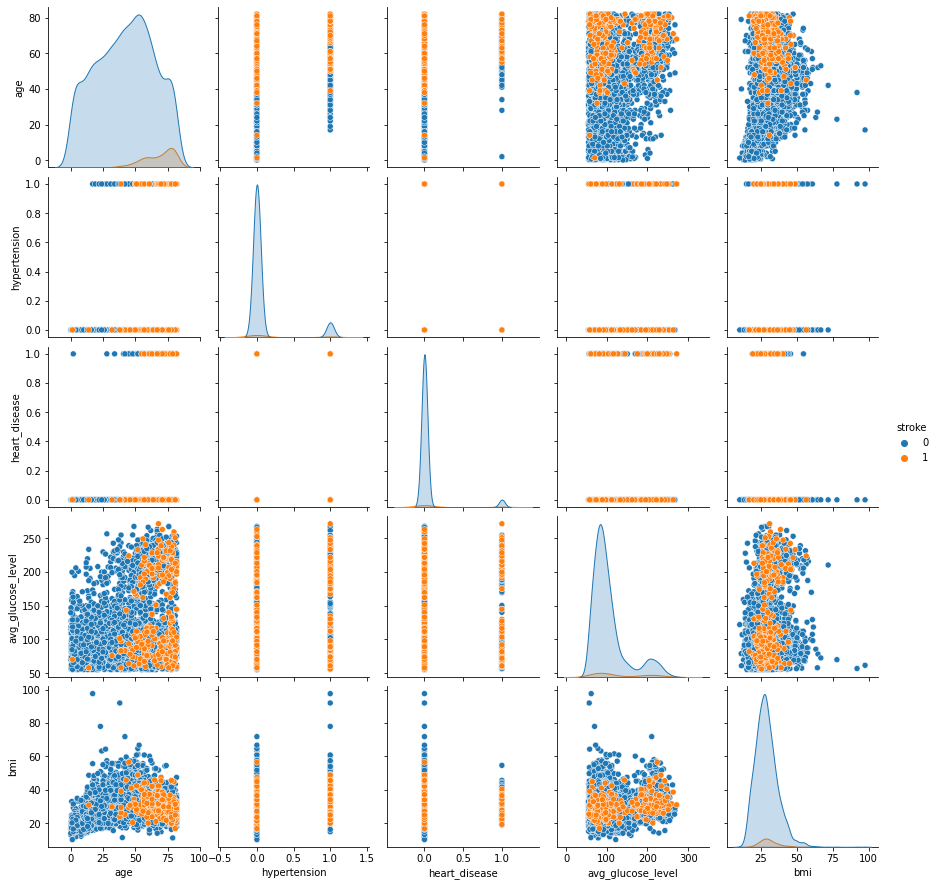

In [14]:
seaborn.pairplot(data.sort_values('stroke'), hue='stroke')
pyplot.savefig("./exploration_figures/pairplot.png")
pyplot.show()

## Oversampling and Undersampling effect on Data Distribution

View different oversampling techniques change our class distribution with ratio 0.3, i.e
$$\frac{\# \text{stroke}}{\# \text{not stroke}} = \frac{3}{10}$$

Run the code block below

In [15]:
transformer = ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough')

models = [Pipeline([('Trans', transformer),
                  ('RandomOverSampler', RandomOverSampler(sampling_strategy=0.3, random_state=1))]),
          Pipeline([('Trans', transformer),
                  ('SMOTE', SMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('SVMSMOTE', SVMSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('BorderlineSMOTE', BorderlineSMOTE(sampling_strategy=0.3))]),
          Pipeline([('Trans', transformer),
                  ('ADASYN', ADASYN(sampling_strategy=0.3))])
          ]

pyplot.figure(figsize=(22, 11))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(data[features], data[target])
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(2, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig('./exploration_figures/oversampling.png')
pyplot.show()

ValueError: A given column is not a column of the dataframe

<Figure size 1584x792 with 0 Axes>

View how different undersampling techniques changes our class distribution.

Run the code block below

In [ ]:
step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))

models = [
          Pipeline([step_trans,
                  ('RandomUnderSampler', RandomUnderSampler(sampling_strategy=0.3))]),
          Pipeline([step_trans,
                  ('OneSidedSelection', OneSidedSelection())]),
          Pipeline([step_trans,
                  ('NeighbourhoodCleaningRule', NeighbourhoodCleaningRule())])
          ]

pyplot.figure(figsize=(22, 7))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(X_train, Y_train)
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 3, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("./exploration_figures/undersampling.png")
pyplot.show()




## 4.6 SMOTE + Tomek Links and SMOTE + Edited Nearest Neighbour

Run the code block below to see how `SMOTETomek` and `SMOTEENN` change class distribution.

In [ ]:
test_size = 0.33
X_train, X_test, Y_train, Y_test = train_test_split(data[features], data['stroke'], test_size=test_size, stratify=data['stroke'])

step_trans = ('Trans', ColumnTransformer([('SimpleImputer', SimpleImputer(), numerical_ix),
                                 ('OrdinalEncoder', OrdinalEncoder(), categorical_ix)],
                                remainder='passthrough'))
step_cart = ('CART', DecisionTreeClassifier())

models = [Pipeline([step_trans,
                  ('SMOTETomek', SMOTETomek(tomek=TomekLinks(sampling_strategy='majority')))]),
          Pipeline([step_trans,
                  ('SMOTEENN', SMOTEENN(enn=EditedNearestNeighbours(sampling_strategy='majority')))])
          ]

pyplot.figure(figsize=(14, 5))
for i in range(len(models)):
    X_over, Y_over = models[i].fit_resample(data[features], data[target])
    data_over = pd.DataFrame(data=X_over, columns=numerical_ix + categorical_ix)
    data_over['stroke'] = Y_over
    pyplot.subplot(1, 2, i + 1)
    seaborn.scatterplot(data=data_over.sort_values('stroke'), x='age', y='avg_glucose_level', hue='stroke', s=20)
    pyplot.title(models[i].steps[-1][0])

pyplot.savefig("./exploration_figures/standard_combine.png")
pyplot.show()

In [ ]:
Y_train
a = data['stroke']
a
